## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import random
import time


## Load Data from CSV File

In [6]:
#load data
data = pd.read_csv('cities.csv')
cities = data['City'].values
coordinates = data[['X', 'Y']].values

#calculate the distance matrix
dist_matrix = cdist(coordinates, coordinates, 'euclidean')


## Stage 1: Single-Solution-Driven Search Algorithm (Simulated Annealing)
Objective Function: Calculate the total distance of a given path.

Simulated Annealing: Adjust a candidate path to minimise total distance.



In [7]:
#Simulated Annealing
def simulated_annealing(dist_matrix, temp=1000, cooling_rate=0.995, max_iter=1000):
    n = len(dist_matrix)
    current_route = list(range(n))
    random.shuffle(current_route)
    current_distance = total_distance(current_route, dist_matrix)

    best_route = current_route
    best_distance = current_distance
    convergence = [best_distance]  # Track convergence

    for i in range(max_iter):
        #Generate neighboring solution
        new_route = current_route[:]
        a, b = random.sample(range(n), 2)
        new_route[a], new_route[b] = new_route[b], new_route[a]
        new_distance = total_distance(new_route, dist_matrix)

        if new_distance < current_distance or np.exp((current_distance - new_distance) / temp) > random.random():
            current_route, current_distance = new_route, new_distance
            if new_distance < best_distance:
                best_route, best_distance = new_route, new_distance

        #cool down and record the best distance at each iteration
        temp *= cooling_rate
        convergence.append(best_distance)

    return best_route, best_distance, convergence


## Runs the SA Algorithm

In [8]:
#Objective function to calculate total distance of a route
def best_distance(route, dist_matrix):
    distance = sum(dist_matrix[route[i], route[i+1]] for i in range(len(route)-1))
    return distance + dist_matrix[route[-1], route[0]]  # return to start

In [9]:
# Run the algorithm
best_route_sa, best_distance_sa, convergence_sa = simulated_annealing(dist_matrix)
print(f"Shortest Distance: {best_distance}")

# Save route to file
with open("best_route.txt", "w") as f:
    for city in best_route_sa:
        f.write(f"{cities[city]}\n")


Shortest Distance: <function best_distance at 0x000001F77C8EB100>


## Stage 2: Population-Driven Search Algorithm (Genetic Algorithm)

In [10]:
#Genetic Algorithm with convergence tracking
def genetic_algorithm_with_convergence(dist_matrix, population_size=100, generations=500, mutation_rate=0.01):
    n = len(dist_matrix)

    def create_route():
        route = list(range(n))
        random.shuffle(route)
        return route

    population = [create_route() for _ in range(population_size)]

    def fitness(route):
        return 1 / total_distance(route, dist_matrix)

    def select_parents():
        return random.choices(population, weights=[fitness(route) for route in population], k=2)

    def crossover(parent1, parent2):
        start, end = sorted(random.sample(range(n), 2))
        child = [-1] * n
        child[start:end] = parent1[start:end]
        ptr = end
        for city in parent2:
            if city not in child:
                if ptr == n: ptr = 0
                child[ptr] = city
                ptr += 1
        return child

    def mutate(route):
        if random.random() < mutation_rate:
            a, b = random.sample(range(n), 2)
            route[a], route[b] = route[b], route[a]

    best_route, best_distance = None, float('inf')
    convergence = []  # Track convergence

    for _ in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents()
            child1, child2 = crossover(parent1, parent2), crossover(parent2, parent1)
            mutate(child1)
            mutate(child2)
            new_population.extend([child1, child2])

        population = sorted(new_population, key=lambda x: total_distance(x, dist_matrix))[:population_size]

        current_best_distance = total_distance(population[0], dist_matrix)
        if current_best_distance < best_distance:
            best_route, best_distance = population[0], current_best_distance

        convergence.append(best_distance)

    return best_route, best_distance, convergence

## Runs Genetic Algorithm

In [11]:
#Runs Genetic Algorithm
best_route_ga, best_distance_ga, convergence_ga = genetic_algorithm_with_convergence(dist_matrix)
print(f"Genetic Algorithm Shortest Distance: {best_distance_ga}")
#save GA route file
with open("best_route_by_GA.txt", "w") as f:
    for city in best_route_ga:
        f.write(f"{cities[city]}\n")


Genetic Algorithm Shortest Distance: 1858.4332298505792


## Performance Visualisation

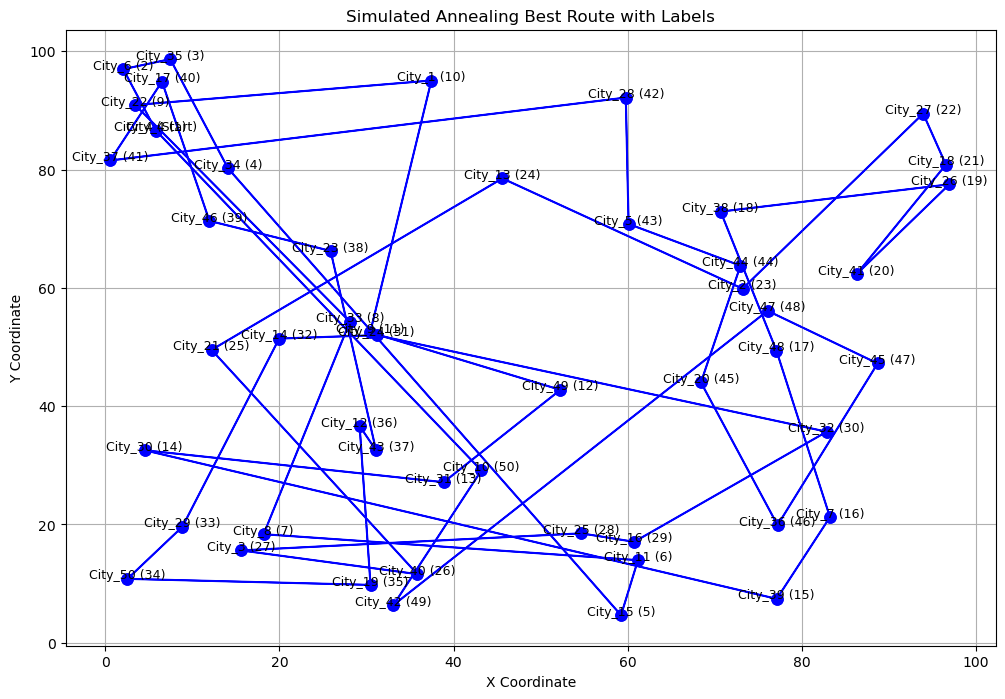

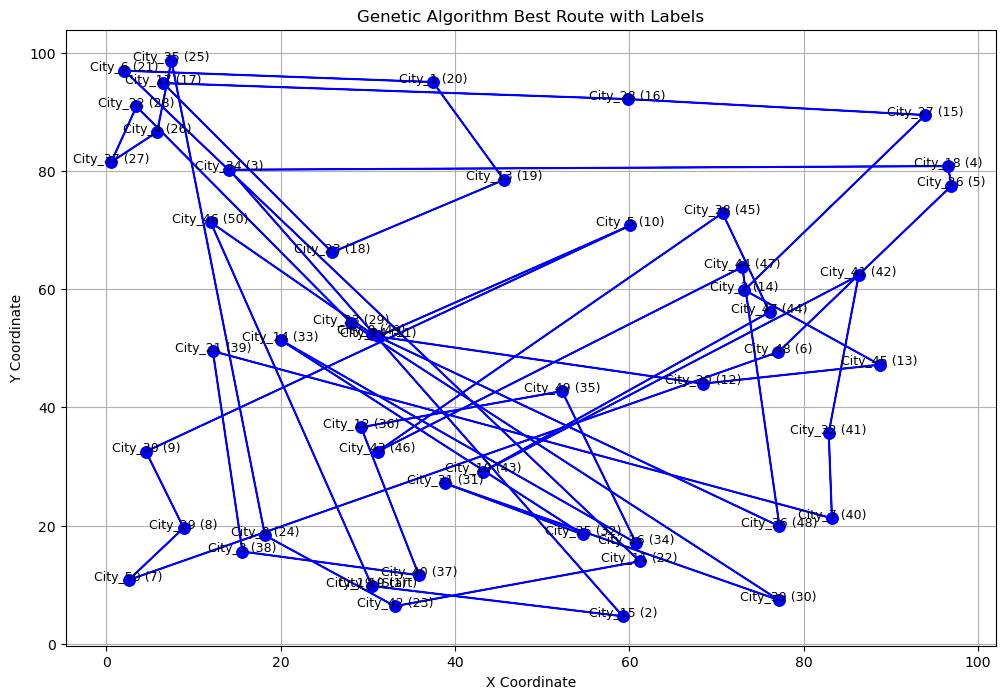

In [47]:
import matplotlib.pyplot as plt
import numpy as np

#visualization function with labels 
def plot_route_with_labels(route, coordinates, city_names, title="Route"):
    #Reorder coordinates according to the route and add the starting point at the end for closure
    route_coords = coordinates[route + [route[0]]]
    route_names = [city_names[i] for i in route] + [city_names[route[0]]]  # Sequence of city names in order

    plt.figure(figsize=(12, 8))
    
    #plot the route with arrows
    for i in range(len(route_coords) - 1):
        plt.plot(
            [route_coords[i][0], route_coords[i + 1][0]],
            [route_coords[i][1], route_coords[i + 1][1]],
            'o-', markersize=8, color='blue'
        )
        
        #add an arrow to indicate direction
        plt.arrow(
            route_coords[i][0], route_coords[i][1],
            route_coords[i + 1][0] - route_coords[i][0],
            route_coords[i + 1][1] - route_coords[i][1],
            head_width=0.5, head_length=0.5, fc='blue', ec='blue'
        )
        
        #Label the city with its name and sequence number
        plt.text(
            route_coords[i][0], route_coords[i][1],
            f"{route_names[i]} ({i + 1})", color='black',
            fontsize=9, ha='center'
        )

    #label the final city 
    plt.text(
        route_coords[-1][0], route_coords[-1][1],
        f"{route_names[-1]} (Start)", color='black',
        fontsize=9, ha='center'
    )

    #add plot title and labels
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid()
    plt.show()

#usage with both Simulated Annealing and Genetic Algorithm routes
plot_route_with_labels(best_route_sa, coordinates, cities, title="Simulated Annealing Best Route with Labels")
plot_route_with_labels(best_route_ga, coordinates, cities, title="Genetic Algorithm Best Route with Labels")


## Evaluate Solution Quality and Computation Time

In [53]:
import time

def evaluate_algorithm(algorithm_func, dist_matrix, runs=5):
    distances = []
    times = []

    for _ in range(runs):
        start_time = time.time()
        _, best_distance, _ = algorithm_func(dist_matrix)
        end_time = time.time()
        
        distances.append(best_distance)
        times.append(end_time - start_time)

    return {
        'Best Distance': min(distances),
        'Average Distance': np.mean(distances),
        'Standard Deviation': np.std(distances),
        'Average Time': np.mean(times)
    }

#evaluate Simulated Annealing
sa_results = evaluate_algorithm(simulated_annealing_with_convergence, dist_matrix)

#evaluate Genetic Algorithm
ga_results = evaluate_algorithm(genetic_algorithm_with_convergence, dist_matrix)

print("Simulated Annealing Results:", sa_results)
print("Genetic Algorithm Results:", ga_results)


Simulated Annealing Results: {'Best Distance': 1318.611992611584, 'Average Distance': 1407.7668248170735, 'Standard Deviation': 84.43114582531585, 'Average Time': 0.04491586685180664}
Genetic Algorithm Results: {'Best Distance': 1844.613942651188, 'Average Distance': 1944.7919957729275, 'Standard Deviation': 52.85394617429237, 'Average Time': 50.50627541542053}


In [55]:
import pandas as pd

#creating a performance comparison table
performance_data = {
    "Algorithm": ["Simulated Annealing", "Genetic Algorithm"],
    "Best Distance": [sa_results['Best Distance'], ga_results['Best Distance']],
    "Average Distance": [sa_results['Average Distance'], ga_results['Average Distance']],
    "Standard Deviation": [sa_results['Standard Deviation'], ga_results['Standard Deviation']],
    "Average Time (s)": [sa_results['Average Time'], ga_results['Average Time']]
}

performance_df = pd.DataFrame(performance_data)
print(performance_df)


             Algorithm  Best Distance  Average Distance  Standard Deviation  \
0  Simulated Annealing    1318.611993       1407.766825           84.431146   
1    Genetic Algorithm    1844.613943       1944.791996           52.853946   

   Average Time (s)  
0          0.044916  
1         50.506275  


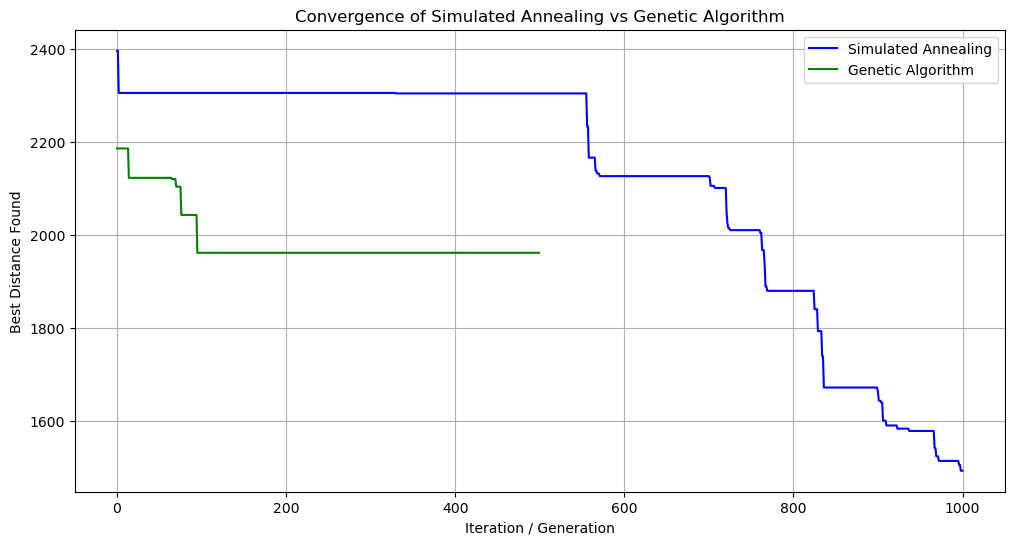

Performance Comparison Table:
             Algorithm  Best Distance  Average Distance  Standard Deviation  \
0  Simulated Annealing    1318.611993       1407.766825           84.431146   
1    Genetic Algorithm    1844.613943       1944.791996           52.853946   

   Average Time (s)  
0          0.044916  
1         50.506275  


In [57]:
#olot convergence trends
plt.figure(figsize=(12, 6))
plt.plot(convergence_sa, label="Simulated Annealing", color='blue')
plt.plot(convergence_ga, label="Genetic Algorithm", color='green')
plt.xlabel("Iteration / Generation")
plt.ylabel("Best Distance Found")
plt.title("Convergence of Simulated Annealing vs Genetic Algorithm")
plt.legend()
plt.grid(True)
plt.show()

print("Performance Comparison Table:")
print(performance_df)
